In [23]:
#### ------------------------------------------------------------------------------------------------------------------------
#### author: Ranjan Barman, date: July 2, 2025
#### predict external BRCA Subtype Status using All HoverNet predicted NPIFs and trained Lasso models from internal CV
#### ------------------------------------------------------------------------------------------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, roc_auc_score, roc_curve, auc
import random
import joblib

# Set working directory
_wpath_ = "/data/Lab_ruppin/Ranjan/HnE/"
os.chdir(_wpath_)
print(f"Working directory = {_wpath_}\n")



Working directory = /data/Lab_ruppin/Ranjan/HnE/



In [24]:
# Define dataset and file paths
dataset_name = "POST_NAT_BRCA"

external_file = f"{dataset_name}/outputs/HoverNet/Subtypes/HoverNet_Original_NPIFs_Values_POST_NAT_BRCA_Mapped_BRCA_Status_Filtered_Tiles_Top25Q.csv"
out_path = f"{dataset_name}/outputs/HoverNet/Subtypes/POST_NAT_BRCA_Predictions/Lasso_HoverNet_All_NPIFs_Filtered_Tiles_Top25Q_Binary_Subtypes/"

model_path = "TCGA_BRCA_FFPE/outputs/HoverNet/Subtypes/Prediction_results_All_HoverNet_NPIFs_Filtered_Tiles_Top25Q_Binary_Subtypes/saved_models/"
os.makedirs(out_path, exist_ok=True)

# Subtype names
subtype_names_3 = ['HER2_Positive', 'HR_Positive', 'TNBC_3']
subtype_names_4 = ['HR+', 'TNBC_4', 'TPBC', 'HER2+']
all_subtypes = subtype_names_3 + subtype_names_4

# Load external dataset
df_external = pd.read_csv(external_file)
df_external.columns = df_external.columns.str.strip()
df_external = df_external[df_external[['HER2_Status', 'PR_Status', 'ER_Status']].isin(["Positive", "Negative"]).all(axis=1)].copy()

df_external


,Patient_ID,HER2_Status,ER_Status,PR_Status,Clinical_subtype,Mean Area,Mean Major Axis,Mean Minor Axis,Mean Perimeter,Mean Eccentricity,Mean Circularity,Std Area,Std Major Axis,Std Minor Axis,Std Perimeter,Std Eccentricity,Std Circularity
0,P1,Negative,Positive,Positive,HR+,10.352435,4.545526,3.075789,12.933216,0.689033,0.749920,4.690496,1.186852,0.709360,3.085005,0.146831,0.093520
1,P10,Negative,Positive,Positive,HR+,9.244911,4.364864,2.888366,12.404201,0.700371,0.733826,4.606881,1.254504,0.704801,3.400931,0.146093,0.104118
2,P11,Negative,Negative,Negative,TNBC,10.982113,4.658496,3.188273,13.379289,0.680822,0.740327,5.706870,1.327943,0.811596,3.578504,0.148359,0.101595
3,P12,Negative,Negative,Negative,TNBC,9.004845,4.347669,2.834071,12.205108,0.710753,0.736480,4.654174,1.234522,0.726943,3.337302,0.146834,0.103760
4,P13,Negative,Negative,Negative,TNBC,14.567301,5.302156,3.669889,15.143500,0.676652,0.758064,7.340379,1.443294,0.941179,3.861904,0.147094,0.088999
5,P14,Negative,Positive,Positive,HR+,14.540743,5.317316,3.568992,15.001859,0.694980,0.752894,8.746110,1.668775,1.047991,4.391279,0.145831,0.094600
6,P15,Negative,Positive,Positive,HR+,9.454632,4.406530,2.926935,12.489124,0.699910,0.738576,4.474902,1.184091,0.721116,3.198260,0.148328,0.102046
7,P16,Negative,Positive,Positive,HR+,11.799307,4.925793,3.222177,13.898565,0.710026,0.730375,6.831412,1.492752,0.935581,4.066019,0.146962,0.107997
8,P17,Negative,Positive,Positive,HR+,11.725796,4.778177,3.266160,13.606413,0.681664,0.751790,6.218606,1.363842,0.882964,3.637754,0.152339,0.099539
9,P18,Negative,Negative,Negative,TNBC,9.531761,4.525995,2.871390,12.747953,0.724608,0.708362,4.879317,1.306762,0.762774,3.457569,0.145862,0.105030


In [25]:
# Define true subtypes from status
def define_true_subtypes(df):
    HER2 = df['HER2_Status'] == 'Positive'
    ER = df['ER_Status'] == 'Positive'
    PR = df['PR_Status'] == 'Positive'

    df['HER2_Positive'] = HER2.astype(int)
    df['HR_Positive'] = ((ER | PR) & ~HER2).astype(int)
    df['TNBC_3'] = (~HER2 & ~ER & ~PR).astype(int)

    df['HR+'] = (ER & ~HER2).astype(int)
    df['TNBC_4'] = (~ER & ~HER2).astype(int)
    df['TPBC'] = (ER & HER2).astype(int)
    df['HER2+'] = (~ER & HER2).astype(int)
    return df

df_external = define_true_subtypes(df_external)

# Extract features
columns_to_exclude = ['sample_id', 'Patient_ID', 'HER2_Status', 'PR_Status', 'ER_Status', 'Clinical_subtype'] + all_subtypes
feature_columns = [col for col in df_external.columns if col not in columns_to_exclude]
X_external = df_external[feature_columns].copy()

X_external



,Mean Area,Mean Major Axis,Mean Minor Axis,Mean Perimeter,Mean Eccentricity,Mean Circularity,Std Area,Std Major Axis,Std Minor Axis,Std Perimeter,Std Eccentricity,Std Circularity
0,10.352435,4.545526,3.075789,12.933216,0.689033,0.749920,4.690496,1.186852,0.709360,3.085005,0.146831,0.093520
1,9.244911,4.364864,2.888366,12.404201,0.700371,0.733826,4.606881,1.254504,0.704801,3.400931,0.146093,0.104118
2,10.982113,4.658496,3.188273,13.379289,0.680822,0.740327,5.706870,1.327943,0.811596,3.578504,0.148359,0.101595
3,9.004845,4.347669,2.834071,12.205108,0.710753,0.736480,4.654174,1.234522,0.726943,3.337302,0.146834,0.103760
4,14.567301,5.302156,3.669889,15.143500,0.676652,0.758064,7.340379,1.443294,0.941179,3.861904,0.147094,0.088999
5,14.540743,5.317316,3.568992,15.001859,0.694980,0.752894,8.746110,1.668775,1.047991,4.391279,0.145831,0.094600
6,9.454632,4.406530,2.926935,12.489124,0.699910,0.738576,4.474902,1.184091,0.721116,3.198260,0.148328,0.102046
7,11.799307,4.925793,3.222177,13.898565,0.710026,0.730375,6.831412,1.492752,0.935581,4.066019,0.146962,0.107997
8,11.725796,4.778177,3.266160,13.606413,0.681664,0.751790,6.218606,1.363842,0.882964,3.637754,0.152339,0.099539
9,9.531761,4.525995,2.871390,12.747953,0.724608,0.708362,4.879317,1.306762,0.762774,3.457569,0.145862,0.105030


In [26]:
# Sample ID list
external_ids = df_external['Patient_ID'].reset_index(drop=True)

# Initialize dataframe to store predictions
external_predictions_df = pd.DataFrame({'Patient_ID': external_ids})
external_predictions_df.set_index('Patient_ID', inplace=True)

# Store true labels
for subtype in all_subtypes:
    external_predictions_df[f'true_label_{subtype}'] = df_external.set_index("Patient_ID")[subtype]

# Prediction function
def predict_external_subtype(subtype_name):
    print(f"\nPredicting subtype: {subtype_name}")
    model_files = sorted([f for f in os.listdir(model_path) if f.startswith(f"{subtype_name}_model_fold_")])
    if not model_files:
        print(f"No model found for {subtype_name}")
        return

    all_preds = []
    for fold_file in model_files:
        model = joblib.load(os.path.join(model_path, fold_file))
        scaler = model.named_steps['scaler']
        classifier = model.named_steps['classifier']

        trained_features = classifier.feature_names_in_ if hasattr(classifier, 'feature_names_in_') else feature_columns
        X_test = X_external[trained_features].copy()
        X_test_scaled = scaler.transform(X_test)

        y_pred = classifier.predict_proba(X_test_scaled)[:, 1]
        all_preds.append(y_pred)

    mean_preds = np.mean(np.column_stack(all_preds), axis=1)
    external_predictions_df[f'predicted_probability_{subtype_name}'] = mean_preds

# Run prediction for all subtypes
for subtype in all_subtypes:
    predict_external_subtype(subtype)

# Save prediction output
output_csv = os.path.join(out_path, "External_POST_NAT_BRCA_Predictions_All_HoverNet_NPIFs_All_Subtypes.csv")
external_predictions_df.to_csv(output_csv)
print(f"\n Predictions saved to: {output_csv}")



Predicting subtype: HER2_Positive

Predicting subtype: HR_Positive

Predicting subtype: TNBC_3

Predicting subtype: HR+

Predicting subtype: TNBC_4

Predicting subtype: TPBC

Predicting subtype: HER2+

 Predictions saved to: POST_NAT_BRCA/outputs/HoverNet/Subtypes/POST_NAT_BRCA_Predictions/Lasso_HoverNet_All_NPIFs_Filtered_Tiles_Top25Q_Binary_Subtypes/External_POST_NAT_BRCA_Predictions_All_HoverNet_NPIFs_All_Subtypes.csv


In [27]:
external_predictions_df

,true_label_HER2_Positive,true_label_HR_Positive,true_label_TNBC_3,true_label_HR+,true_label_TNBC_4,true_label_TPBC,true_label_HER2+,predicted_probability_HER2_Positive,predicted_probability_HR_Positive,predicted_probability_TNBC_3,predicted_probability_HR+,predicted_probability_TNBC_4,predicted_probability_TPBC,predicted_probability_HER2+
Patient_ID,,,,,,,,,,,,,,
P1,0,1,0,1,0,0,0,0.226591,0.740023,0.352037,0.716985,0.381927,0.310035,0.050781
P10,0,1,0,1,0,0,0,0.068889,0.838231,0.469783,0.820470,0.499998,0.212549,0.001048
P11,0,0,1,0,1,0,0,0.205007,0.681018,0.471816,0.659283,0.511180,0.278163,0.055288
P12,0,0,1,0,1,0,0,0.209954,0.680178,0.417076,0.632640,0.493566,0.364948,0.012808
P13,0,0,1,0,1,0,0,0.212923,0.592652,0.521433,0.500441,0.544710,0.356126,0.032798
P14,0,1,0,1,0,0,0,0.567803,0.045177,0.886216,0.018509,0.917377,0.435291,0.689445
P15,0,1,0,1,0,0,0,0.223442,0.769923,0.321624,0.765866,0.346925,0.382337,0.015095
P16,0,1,0,1,0,0,0,0.528268,0.297945,0.618972,0.283507,0.639851,0.478616,0.554423
P17,0,1,0,1,0,0,0,0.494648,0.424749,0.461906,0.390034,0.492581,0.477799,0.371099


In [28]:
# Mapping for 3-subtype ROC plotting
subtypes_3 = {
    'HER2_Positive': ('true_label_HER2_Positive', 'predicted_probability_HER2_Positive'),
    'HR_Positive': ('true_label_HR_Positive', 'predicted_probability_HR_Positive'),
    'TNBC_3': ('true_label_TNBC_3', 'predicted_probability_TNBC_3')
}

# Mapping for 4-subtype ROC plotting
subtypes_4 = {
    'HR+': ('true_label_HR+', 'predicted_probability_HR+'),
    'TNBC_4': ('true_label_TNBC_4', 'predicted_probability_TNBC_4'),
    'TPBC': ('true_label_TPBC', 'predicted_probability_TPBC'),
    'HER2+': ('true_label_HER2+', 'predicted_probability_HER2+')
}


In [29]:
colors = {
    'HER2_Positive': 'darkorange',
    'HR_Positive': 'blue',
    'TNBC_3': 'green',
    'HR+': 'blue',
    'TNBC_4': 'green',
    'TPBC': 'tomato',
    'HER2+': 'darkorange'
}
def plot_combined_roc_curves(df, subtypes, title, filename):
    plt.figure(figsize=(10, 8))
    total_samples = len(df)

    for subtype, (true_label_col, pred_prob_col) in subtypes.items():
        if subtype in ['TNBC_3', 'TNBC_4']:
            if 'TNBC' in colors:  # Avoid duplicated legend for TNBC
                continue
            label = 'TNBC'
        elif subtype == 'HER2_Positive':
            label = 'HER2+'
        elif subtype == 'HR_Positive':
            label = 'HR+'
        else:
            label = subtype

        # Filter valid entries
        valid_indices = (~df[true_label_col].isna()) & (~df[pred_prob_col].isna())
        true_labels = df[true_label_col][valid_indices]
        predicted_probs = df[pred_prob_col][valid_indices]

        # Compute ROC and AUC
        fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
        roc_auc = auc(fpr, tpr)

        # Plot
        plt.plot(fpr, tpr, color=colors[subtype], lw=2,
                 label=f'{label} (AUC = {roc_auc:.2f}, n = {true_labels.sum():.0f})')

    # Reference diagonal
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc="lower right", fontsize=18)
    plt.grid(True)

    # Save and show
    plt.savefig(os.path.join(out_path, filename), bbox_inches='tight')
    plt.show()


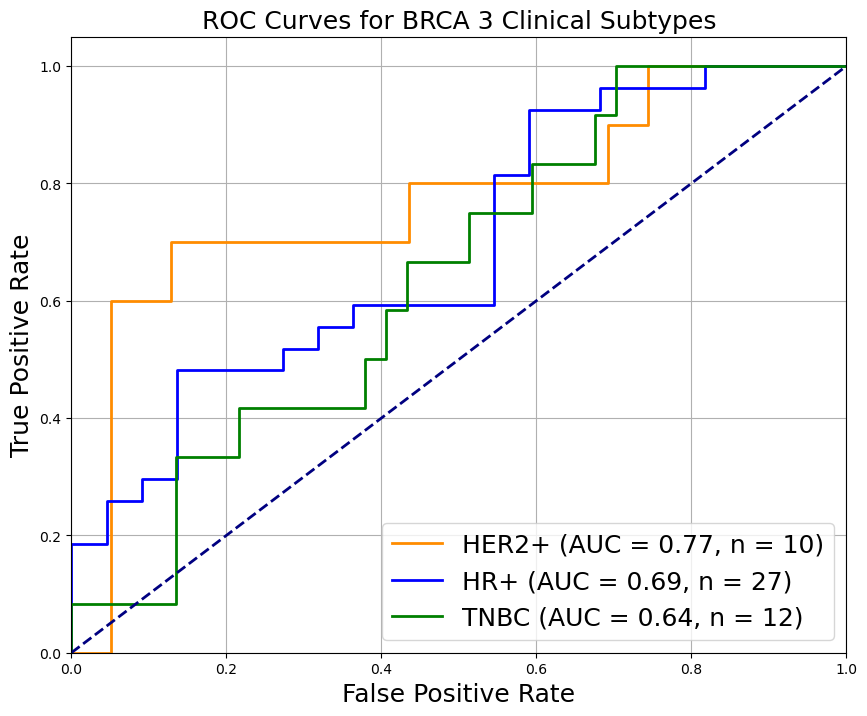

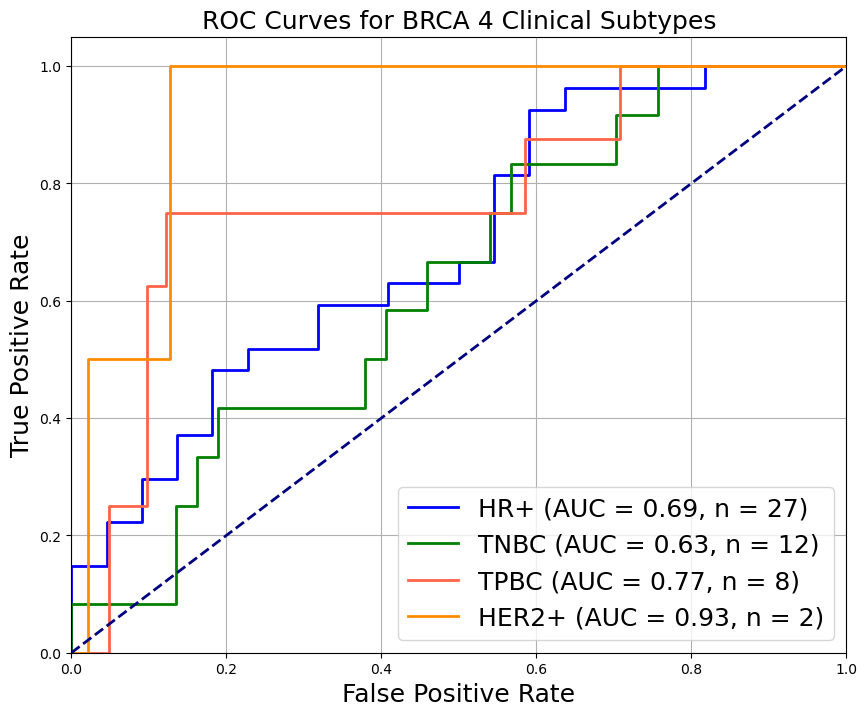

In [30]:
plot_combined_roc_curves(
    external_predictions_df,
    subtypes_3,
    'ROC Curves for BRCA 3 Clinical Subtypes',
    'roc_3_subtypes.png'
)

plot_combined_roc_curves(
    external_predictions_df,
    subtypes_4,
    'ROC Curves for BRCA 4 Clinical Subtypes',
    'roc_4_subtypes.png'
)



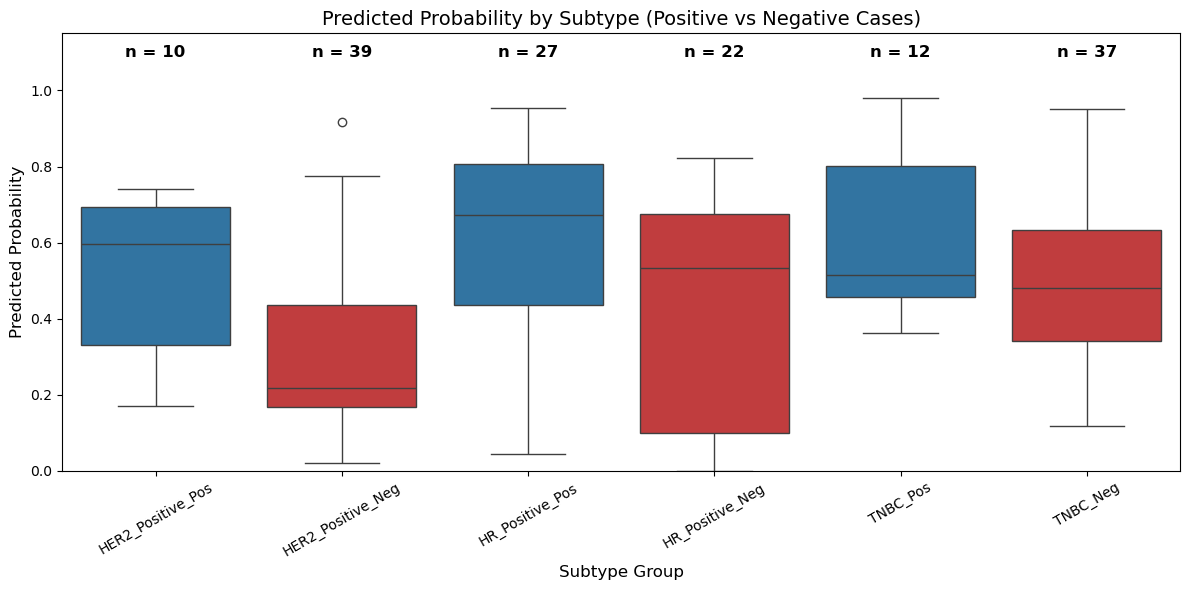

In [31]:
# Prepare positive and negative subsets using true label columns
HER2_pos = external_predictions_df[external_predictions_df['true_label_HER2_Positive'] == 1]
HER2_neg = external_predictions_df[external_predictions_df['true_label_HER2_Positive'] == 0]

HR_pos = external_predictions_df[external_predictions_df['true_label_HR_Positive'] == 1]
HR_neg = external_predictions_df[external_predictions_df['true_label_HR_Positive'] == 0]

TNBC_pos = external_predictions_df[external_predictions_df['true_label_TNBC_3'] == 1]
TNBC_neg = external_predictions_df[external_predictions_df['true_label_TNBC_3'] == 0]

# Construct a DataFrame for boxplot visualization
plot_df = pd.DataFrame({
    'Subtype_Label': ['HER2_Positive_Pos'] * len(HER2_pos) +
                     ['HER2_Positive_Neg'] * len(HER2_neg) +
                     ['HR_Positive_Pos'] * len(HR_pos) +
                     ['HR_Positive_Neg'] * len(HR_neg) +
                     ['TNBC_Pos'] * len(TNBC_pos) +
                     ['TNBC_Neg'] * len(TNBC_neg),
    'Predicted_Probability': pd.concat([
        HER2_pos['predicted_probability_HER2_Positive'],
        HER2_neg['predicted_probability_HER2_Positive'],
        HR_pos['predicted_probability_HR_Positive'],
        HR_neg['predicted_probability_HR_Positive'],
        TNBC_pos['predicted_probability_TNBC_3'],
        TNBC_neg['predicted_probability_TNBC_3']
    ], axis=0)
})

# Define color palette for positive/negative cases
palette = {
    'HER2_Positive_Pos': '#1f77b4',
    'HER2_Positive_Neg': '#d62728',
    'HR_Positive_Pos': '#1f77b4',
    'HR_Positive_Neg': '#d62728',
    'TNBC_Pos': '#1f77b4',
    'TNBC_Neg': '#d62728'
}

# Create the boxplot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=plot_df,
    x='Subtype_Label',
    y='Predicted_Probability',
    hue='Subtype_Label',
    palette=palette,
    legend=False
)

# Annotate sample sizes above each box
group_counts = plot_df['Subtype_Label'].value_counts()
for tick, label in enumerate(ax.get_xticklabels()):
    subtype = label.get_text()
    count = group_counts[subtype]
    ax.text(tick, 1.08, f'n = {count}', ha='center', va='bottom',
            fontsize=12, fontweight='bold', color='black')

# Final formatting
ax.set_ylim(0, 1.15)
plt.title("Predicted Probability by Subtype (Positive vs Negative Cases)", fontsize=14)
plt.xlabel("Subtype Group", fontsize=12)
plt.ylabel("Predicted Probability", fontsize=12)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


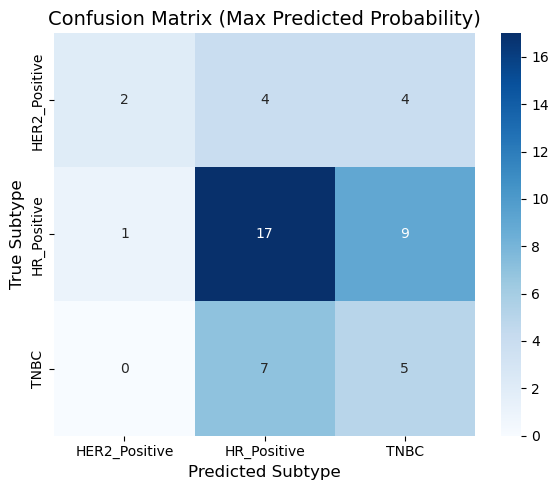

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define subtype labels
subtypes = ['HER2_Positive', 'HR_Positive', 'TNBC']

# Step 1: Define true labels using true_label_<subtype> columns
def get_true_subtype(row):
    if row['true_label_HER2_Positive'] == 1:
        return 'HER2_Positive'
    elif row['true_label_HR_Positive'] == 1:
        return 'HR_Positive'
    elif row['true_label_TNBC_3'] == 1:
        return 'TNBC'
    else:
        return 'Unknown'

# Step 2: Assign predicted subtype using max of predicted probabilities
def get_predicted_subtype(row):
    probs = {
        'HER2_Positive': row['predicted_probability_HER2_Positive'],
        'HR_Positive': row['predicted_probability_HR_Positive'],
        'TNBC': row['predicted_probability_TNBC_3']
    }
    return max(probs, key=probs.get)

# Apply true and predicted subtype logic
external_predictions_df['true_subtype'] = external_predictions_df.apply(get_true_subtype, axis=1)
external_predictions_df['predicted_subtype'] = external_predictions_df.apply(get_predicted_subtype, axis=1)

# Step 3: Filter valid rows (exclude ambiguous/unknown cases)
valid_df = external_predictions_df[external_predictions_df['true_subtype'] != 'Unknown']

# Step 4: Compute confusion matrix
cm = confusion_matrix(valid_df['true_subtype'], valid_df['predicted_subtype'], labels=subtypes)

# Step 5: Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=subtypes, yticklabels=subtypes)
plt.xlabel("Predicted Subtype", fontsize=12)
plt.ylabel("True Subtype", fontsize=12)
plt.title("Confusion Matrix (Max Predicted Probability)", fontsize=14)
plt.tight_layout()
plt.show()


In [33]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define subtype order
subtypes = ['HER2_Positive', 'HR_Positive', 'TNBC']

# Step 1: Extract true and predicted labels
y_true = valid_df['true_subtype']
y_pred = valid_df['predicted_subtype']

# Step 2: Compute overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

# Step 3: Generate classification report for defined subtypes
report = classification_report(y_true, y_pred, labels=subtypes, output_dict=True)

# Step 4: Compute per-class metrics using confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=subtypes)
balanced_accuracies = []
specificities = []
recalls = []

for i, label in enumerate(subtypes):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # same as recall
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    balanced_accuracy = (sensitivity + specificity) / 2

    recalls.append(round(sensitivity, 4))
    specificities.append(round(specificity, 4))
    balanced_accuracies.append(round(balanced_accuracy, 4))

# Step 5: Create metrics dataframe in required column order
metrics_df = pd.DataFrame({
    'balanced_accuracy': balanced_accuracies,
    'sensitivity (recall)': recalls,
    'specificity': specificities,
    'precision': [report[label]['precision'] for label in subtypes],
    'f1-score': [report[label]['f1-score'] for label in subtypes],
    'support': [report[label]['support'] for label in subtypes],
}, index=subtypes)

# Step 6: Round for display
metrics_df = metrics_df.round(4)

# Step 7: Compute and print mean balanced accuracy
mean_balanced_accuracy = round(sum(balanced_accuracies) / len(balanced_accuracies), 4)
print(f"\nMean Balanced Accuracy: {mean_balanced_accuracy:.4f}")

# Step 8: Print final metrics
print("\nPer-Class Performance Metrics:")
metrics_df



Overall Accuracy: 0.4898

Mean Balanced Accuracy: 0.5616

Per-Class Performance Metrics:


,balanced_accuracy,sensitivity (recall),specificity,precision,f1-score,support
HER2_Positive,0.5872,0.2000,0.9744,0.6667,0.3077,10.0
HR_Positive,0.5648,0.6296,0.5000,0.6071,0.6182,27.0
TNBC,0.5327,0.4167,0.6486,0.2778,0.3333,12.0
